In [1]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable


2.860133409500122
torch.Size([32, 18])
torch.Size([32])
torch.Size([32])
0.0
32
2.860133409500122
2.849282741546631
torch.Size([19, 18])
torch.Size([19])
torch.Size([19])
0.0
51
2.849282741546631
Epoch 1/200, Loss: 2.85471, Accuracy: 0.00000
2.8399534225463867
torch.Size([32, 18])
torch.Size([32])
torch.Size([32])
0.0
32
2.834181070327759
torch.Size([19, 18])
torch.Size([19])
torch.Size([19])
0.0
51
Epoch 2/200, Loss: 2.83707, Accuracy: 0.00000
2.822571039199829
torch.Size([32, 18])
torch.Size([32])
torch.Size([32])
0.0
32
2.8142497539520264
torch.Size([19, 18])
torch.Size([19])
torch.Size([19])
0.0
51
Epoch 3/200, Loss: 2.81841, Accuracy: 0.00000
2.802816152572632
torch.Size([32, 18])
torch.Size([32])
torch.Size([32])
0.0
32
2.7966957092285156
torch.Size([19, 18])
torch.Size([19])
torch.Size([19])
0.0
51
Epoch 4/200, Loss: 2.79976, Accuracy: 0.00000
2.784008741378784
torch.Size([32, 18])
torch.Size([32])
torch.Size([32])
0.0
32
2.773848533630371
torch.Size([19, 18])
torch.Size([19])
t

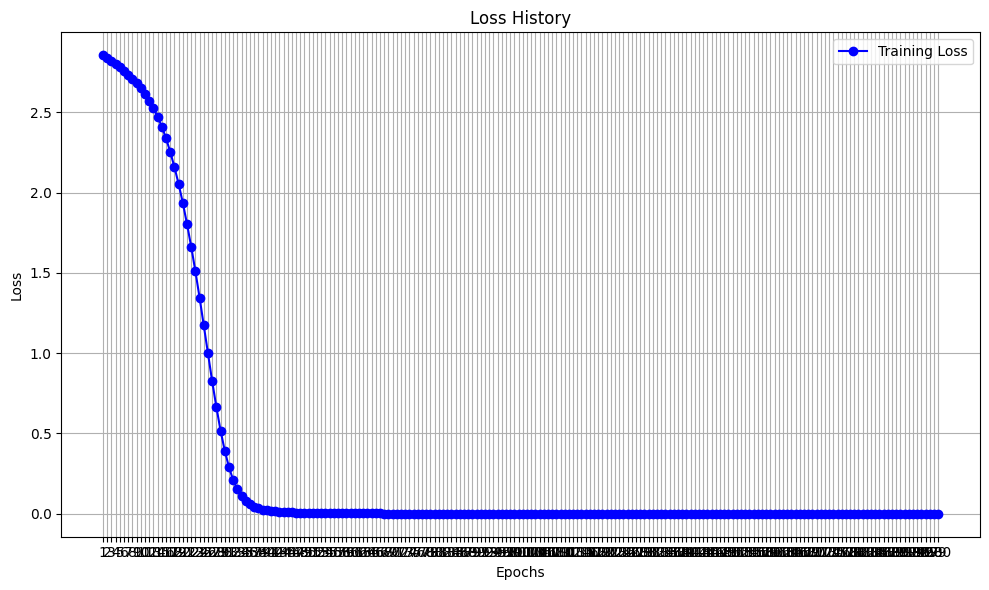

1


In [13]:
# 순방향 신경망(Feedforward Neural Network) -> 다층 퍼셉트론(MLP: Multi-Layer Perceptron)
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import random
import glob
import string

unknown_char,padding = '?','_'
all_letters = string.ascii_lowercase + unknown_char + padding
category_names,all_categories = {},[]
max_word_length,batch_size = 10,32
len_all_categories=0
test_size,val_size = 0.2, 0.1

def activate_config(unknown_char='?', padding='_', max_word_length=10, batch_size=32, test_size=0.2, val_size=0.1):
    unknown_char,padding = unknown_char,padding
    all_letters = string.ascii_lowercase + unknown_char + padding
    max_word_length,batch_size = max_word_length,batch_size
    test_size=test_size
    val_size=val_size

def category_to_tensor(idx, N):
    return torch.tensor([(i==idx)/1 for i in range(N)])

def input_padding_and_unknown_char_handling(word):
    word = ''.join(char if char in string.ascii_lowercase else unknown_char for char in word.lower())
    return word + '_'*(10 - len(word)) if len(word)!=10 else word

def word_to_tensor(word):
    word = input_padding_and_unknown_char_handling(word)
    res = torch.zeros(len(word), len(all_letters))
    for idx, letter in enumerate(word):
        res[idx][all_letters.find(letter)] = 1
    # print(word, res, res.shape)
    return res #.squeeze(dim = 1) # shape(10,28)    

def preprocessing_data(batch_size = 32, test_size=0.2, val_size=0.1):
    files = glob.glob('./data/names/*.txt')
    # print(f'{len(files)}fiels',*files,sep='\n')
    
    for file in files:
        with open(file) as f:
            words = f.read().strip().split('\n')
        category = file.split('\\')[-1].split('.')[0]
        all_categories.append(category)

        words = [word for word in words if len(word) <= max_word_length]
        category_names[category] = words
        # print(f'{category}: {len(words)} |', *words[0:10])
    # print(all_categories)
    # print(category_names)

    
    for category, words in category_names.items():
        x = [word_to_tensor(word) for word in words]
        y = [torch.tensor(all_categories.index(category)) for word in words]
    
    x = torch.stack(x)
    y = torch.stack(y)

    x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=(test_size + val_size))
    x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=(test_size / (test_size + val_size)))
    
    train_dataset = TensorDataset(x_train, y_train)
    val_dataset = TensorDataset(x_val, y_val)
    test_dataset = TensorDataset(x_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

def plot_loss_history(loss_history, val_loss_history=None): # 훈련손실, 검증손실
    plt.figure(figsize=(10, 6)) 
    plt.plot(range(1, len(loss_history) + 1), loss_history, label='Training Loss', color='blue', marker='o')
    if val_loss_history is not None: plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, label='Validation Loss', color='orange', marker='x')
    plt.title('Loss History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(range(1, len(loss_history) + 1)) # x축 눈금 설정
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.hidden_size = hidden_size
        
        self.input_hidden = nn.Linear(input_size, hidden_size)
        self.hidden_hidden = nn.Linear(hidden_size, hidden_size)
        self.hidden_output = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim = 1) # 출력값을 확률분포로 변환
        self.optimizer = optim.Adam # 다양한 이동 평균(학습률)을 적용하여 손실함수 최적화 # 모델의 파라미터(가중치)를 업데이트하여 손실을 최소화하는 역할
        self.loss = torch.nn.NLLLoss() # 모델의 예측과 실제 값 간의 차이를 측정 : 다중 클래스 분류문제에서 모델성능평가에 사용되는 중요 손실함수

    def forward(self, input):
        hidden = self.relu(self.input_hidden(input))
        hidden = self.relu(self.hidden_hidden(hidden))
        output = self.hidden_output(hidden)
        output = self.softmax(output)
        return output
    
    def train_model(self, train_data, learning_rate = 0.001, epochs = 20):
        optimizer = self.optimizer(self.parameters(), lr = learning_rate)
        loss_history = []

        for epoch in range(epochs):
            running_loss = 0.0
            correct_predictions = 0
            total_predictions = 0
            
            for input, label in train_data:
                input = input.reshape(input.size(0), input.size(1)*input.size(2))
                label = label.long()  # label을 LongTensor로 변환
                # hidden = self.initHidden() # 은닉상태 초기화 # MLP는 시간적인 정보를 처리하지 않아 히든상태의 개념이 없다 무의미하다#RNN은 반복되어 필수
                optimizer.zero_grad()
                output = self(input)# 전체 입력 처리
                # print(output)
                
                loss = self.loss(output, label)
                loss.backward() # 기울기 누적
                optimizer.step() # 파라미터 업데이트
                
                running_loss += loss.item() # 손실기록
                
                print(torch.mean(loss).item())
                print(output.shape)
                # predicted = output.argmax(1)  # 가장 높은 확률의 인덱스
                predicted = torch.argmax(output, 1)  # 가장 높은 확률의 인덱스
                
                print(predicted.shape)
                print(label.shape)
                correct_predictions += (predicted == label).float().sum().item()  # 맞춘 예측 개수
                total_predictions += label.size(0)  # 총 예측 개수
                print(correct_predictions)
                print(total_predictions)
                
                if len(loss_history)%1000 == 0:
                    print(torch.mean(loss).item())
            
            
            epoch_loss = running_loss / len(train_data)
            accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0 # 정확도 계산
            print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.5f}, Accuracy: {accuracy:.5f}') # 정확도 출력
            loss_history.append(epoch_loss)  # 손실 기록
        plot_loss_history(loss_history)
        return loss_history

def predict_nationality(model, word):
    word_tensor = word_to_tensor(word).unsqueeze(0)
    print(word_tensor.shape)
    
    output = model(word_tensor)
    _, predicted_index = torch.max(output, 1)
    return predicted_index

activate_config(unknown_char='?', padding='_',
                max_word_length=10, batch_size=32,
                test_size=0.2, val_size=0.1)
train_loader, val_loader, test_loader = preprocessing_data(batch_size,test_size,val_size)

model = MLP(input_size=len(all_letters)*10, hidden_size=32, output_size=len(all_categories))
# predict_nationality(model, 'ang')

model.train_model(train_loader, learning_rate = 0.001, epochs = 200)
print(1)

오늘은 지금까지 배운 전반부 딥러닝에서의 내용을 총체적으로 활용하여 문제를 직접 a부터 z까지 해결해보는 시간입니다.

오늘 다룰 데이터는 names 안에 있는 각국의 이름을 받아, 이름의 국적을 추론하는 뉴럴 넷을 만드는 것입니다. 방법은 자유이나, 다음의 두 가지 방법을 꼭 포함시켜 구현하고, 성능 측정/튜닝의 과정을 거치세요.

1. Feedforward Network(MLP)를 사용하여 해볼 것.
  -  Feedforward Network를 이용하여 할 경우, input size가 이름에 따라 다른데 이를 어떤 식으로 다룰지 생각해 볼 것
2. RNN을 이용하여 해볼 것.
  - torch.DataLoader을 사용할 경우 batching을 하게 되는데, 이 경우 위 1에서 써 있는 문제와 비슷한 문제가 있으며 해결 또한 비슷하게 할 수 있음. torch.DataLoader을 쓸 때와 쓰지 않을 때를 비교해볼 것.
  - 어제는 영어 알파벳만 사용하였는데, 다른 알파벳까지 사용할 경우 성능이 올라가는지 내려가는지 관찰해볼 것.
  - 데이터에서 관찰하지 못한 알파벳들을 OOV로 처리하는 방식을 시도할 경우 성능이 올라가는지 내려가는지 관찰해볼 것

성능 측정을 위해서 train-valid-test를 적절히 나누고, valid에서의 loss와 정확도를 측정하면서 학습을 적절할 때 멈추거나 할 것.

튜닝을 위해서는 다음의 방법들을 사용할 수 있습니다.

- hyperparameter을 다양하게 시도해볼 것
- 뉴럴 넷 구조를 조금씩 바꿔볼 것
- 데이터를 더 만들어 볼 것

In [3]:
from collections import defaultdict

d = defaultdict(int)

for i in range(10):
    d[i] += 1
print(d)

defaultdict(<class 'int'>, {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1})


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import glob
import matplotlib.pyplot as plt

from collections import defaultdict
from torch.utils.data import DataLoader, TensorDataset
def generate_dataset(batch_size = 32):
    files = glob.glob('./data/names/*.txt')

    assert len(files) == 18

    character_dict = defaultdict(int)
    name_length_dict = defaultdict(int)

    data = []
    languages = []

    for file in files:
        with open(file) as f:
            names = f.read().strip().split('\n')
        lang = file.split('/')[1].split('.')[0]

        if lang not in languages:
            languages.append(lang)

        for name in names:
            for char in name:
                character_dict[char.lower()] += 1
            name_length_dict[len(name)] += 1
            data.append([name, lang])

    lst = []
    for k, v in character_dict.items():
        lst.append((k, v))

    name_length_lst = []
    for k, v in name_length_dict.items():
        name_length_lst.append((k, v))

    lst = sorted(lst, key = lambda x:x[1], reverse = True)
    name_length_lst = sorted(name_length_lst, key = lambda x:x[1], reverse = True)

    total_count = sum([e[1] for e in lst])
    total_count_name = sum([e[1] for e in name_length_lst])

    s = 0
    alphabets = []

    oov = '[OOV]'
    pad = '[PAD]'

    for k, v in lst:
        s += v
        if s < 0.999*total_count:
            alphabets.append(k)
    s = 0
    max_length_candidate = []
    for k, v in name_length_lst:
        s += v
        if s < 0.999*total_count_name:
            max_length_candidate.append(k)

    alphabets.append(oov)

    for elem in data:
        tmp = []
        for char in data[0]:
            if char in alphabets:
                tmp.append(char)
            else:
                tmp.append(oov)
        data[0] = word2tensor(tmp)

    x = torch.stack([e[0] for e in data])
    y = torch.stack([torch.tensor(e[1]) for e in data])

    dataset = TensorDataset(x, y)
    dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

    return dataloader


# now the data is list of[list of character, lang_name]

alphabets = 'abcdefghijklmnopqrstuvwxzy'
max_length = 17



dataset = generate_dataset()
print(dataset)

TypeError: word2tensor() missing 2 required positional arguments: 'max_length' and 'alphabets'

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import glob
import matplotlib.pyplot as plt

from collections import defaultdict
from torch.utils.data import DataLoader, TensorDataset

OOV = '[OOV]'
PAD = '[PAD]'

# hyperparameters
batch_size = 32

def letter2tensor(letter, alphabets, oov = OOV):
    res = [0 for _ in range(len(alphabets))]

    if letter in alphabets:
        idx = alphabets.index(letter)
    else:
        idx = alphabets.index(oov)

    res[idx] = 1

    return torch.tensor(res)

def word2tensor(word, max_length, alphabets, pad = PAD, oov = OOV):
    # return torch.tensor with size (max_length, len(alphabets))
    res = torch.zeros(max_length, len(alphabets))

    for idx, char in enumerate(word):
        if idx < max_length:
            res[idx] = letter2tensor(char, alphabets, oov = oov)

    for i in range(max_length - len(word)):
        res[len(word) + i] = letter2tensor(pad, alphabets, oov = oov)

    return res

def determine_alphabets(data, pad = PAD, oov = OOV, threshold = 0.999):
    # data = list of [name, language_name]
    lst = []
    character_dict = defaultdict(int)

    for name, lang in data:
        for char in name:
            character_dict[char.lower()] += 1

    for k, v in character_dict.items():
        lst.append((k, v))

    lst = sorted(lst, key = lambda x:x[1], reverse = True)
    total_count = sum([e[1] for e in lst])
    s = 0

    alphabets = []

    for k, v in lst:
        s += v
        if s < threshold * total_count:
            alphabets.append(k)

    alphabets.append(pad)
    alphabets.append(oov)

    return alphabets

def determine_max_length(data, threshold = 0.99):
    lst = []
    name_length_dict = defaultdict(int)

    for name, lang in data:
         name_length_dict[len(name)] += 1

    for k, v in name_length_dict.items():
        lst.append((k, v))

    lst = sorted(lst, key = lambda x:x[1], reverse = True)
    total_count = sum([e[1] for e in lst])
    s = 0

    for k, v in lst:
        s += v
        if s > threshold * total_count:
            return k - 1
    # if not, return the maximum value in lst
    return max(lst, key = lambda x:x[0])[0]

def load_file(): 
    files = glob.glob('./data/names/*.txt')
    
    assert len(files) == 18

    data = []
    languages = []

    for file in files:
        with open(file) as f:
            names = f.read().strip().split('\n')
        lang = file.split('/')[1].split('.')[0]

        if lang not in languages:
            languages.append(lang)

        for name in names:
            data.append([name, lang])

    return data, languages

def generate_dataset(batch_size = 32, pad = PAD, oov = OOV):
    data, languages = load_file()

    alphabets = determine_alphabets(data, pad = pad, oov = oov)
    max_length = determine_max_length(data)
    print(alphabets, max_length)

    for idx, elem in enumerate(data):
        tmp = []
        for char in elem[0]:
            if char.lower() in alphabets:
                tmp.append(char.lower())
            else:
                tmp.append(oov)

        data[idx][0] = word2tensor(tmp, max_length, alphabets, pad = pad, oov = oov)
        data[idx][1] = languages.index(data[idx][1])

    x = [e[0] for e in data]
    y = [torch.tensor(e[1]) for e in data]

    train_x, train_y, valid_x, valid_y, test_x, test_y = split_train_valid_test(x, y)

    train_x = torch.stack(train_x)
    train_y = torch.stack(train_y)
    valid_x = torch.stack(valid_x)
    valid_y = torch.stack(valid_y)
    test_x = torch.stack(test_x)
    test_y = torch.stack(test_y)

    train_dataset = TensorDataset(train_x, train_y)
    valid_dataset = TensorDataset(valid_x, valid_y)
    test_dataset = TensorDataset(test_x, test_y)

    train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    valid_dataloader = DataLoader(valid_dataset, batch_size = batch_size, shuffle = True)
    test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

    return train_dataloader, valid_dataloader, test_dataloader, alphabets, max_length, languages

train_dataset, valid_dataset, test_dataset, alphabets, max_length, languages  = generate_dataset()

['a', 'o', 'e', 'i', 'n', 'r', 's', 'h', 'k', 'l', 'v', 't', 'u', 'm', 'd', 'b', 'y', 'g', 'c', 'z', 'f', 'p', 'j', 'w', ' ', 'q', "'", 'x', '-', '철', '[PAD]', '[OOV]'] 12


NameError: name 'split_train_valid_test' is not defined

In [ ]:
for x, y in dataset:
    print(x.shape, y.shape)
    break

In [ ]:
t = torch.randn(3,4,2)
print(t)
print(t.reshape(3, 8))

In [12]:
def tensor2word(t, alphabets):
    # t.shpae: max_length, len(alphabets)
    res = []
    for char_tensor in t:
        char = alphabets[int(torch.argmax(char_tensor).item())]
        res.append(char)

    return res

def idx2lang(idx, languages):
    return languages[idx]

for batch_x, batch_y in dataset:
    for i in range(batch_x.size(0)):
        print(tensor2word(batch_x[i], alphabets), idx2lang(batch_y[i], languages))
    break


AttributeError: 'list' object has no attribute 'size'

In [11]:
import random

def pick_train_valid_test(train, valid, test):
    assert [train, valid, test] != [0, 0, 0]
    options = [train, valid, test]

    pick = random.choice([0, 1, 2])

    while options[pick] == 0:
        pick = random.choice([0, 1, 2])
    assert options[pick] != 0
    return pick

print(pick_train_valid_test(0,3,0))

1


In [8]:
t = torch.tensor([1.0, 2.0])
print(t.dtype)

torch.float32


In [10]:
import random
import pickle

def modify_dataset_for_ffn(dataset):
    x = []
    y = []

    for batch_x, batch_y in dataset:
        for i in range(batch_x.size(0)):
            x.append(batch_x[i].reshape((batch_x.size(1) * batch_x.size(2))))
            y.append(batch_y[i])

    train_x, train_y, valid_x, valid_y, test_x, test_y = split_train_valid_test(x, y)

    train_x = torch.stack(train_x)
    train_y = torch.stack(train_y)
    valid_x = torch.stack(valid_x)
    valid_y = torch.stack(valid_y)
    test_x = torch.stack(test_x)
    test_y = torch.stack(test_y)

    train_dataset = TensorDataset(train_x, train_y)
    valid_dataset = TensorDataset(valid_x, valid_y)
    test_dataset = TensorDataset(test_x, test_y)

    train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    valid_dataloader = DataLoader(valid_dataset, batch_size = batch_size, shuffle = True)
    test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

    return train_dataloader, valid_dataloader, test_dataloader

def pick_train_valid_test(train, valid, test):
    assert [train, valid, test] != [0, 0, 0]
    options = [train, valid, test]

    pick = random.choice([0, 1, 2])

    while options[pick] == 0:
        pick = random.choice([0, 1, 2])
    assert options[pick] != 0
    return pick

def split_train_valid_test(x, y, train_valid_test_ratio = (0.7, 0.15, 0.15)):
    # TensorDataset -> TensorDataset, TensorDataset, TensorDataset
    # x, y: list of data
    train_ratio, valid_ratio, test_ratio = train_valid_test_ratio
    y_label_dict = defaultdict(int)
    for y_data in y:
        y_label_dict[y_data.item()] += 1

    no_per_labels = {} # y_label별로 각각 train, valid, test

    for y_label, freq in y_label_dict.items():
        train_size, valid_size, test_size = int(freq * train_ratio), int(freq * valid_ratio), freq - int(freq * train_ratio) - int(freq * valid_ratio)
        no_per_labels[y_label] = [train_size, valid_size, test_size]

    train_x, train_y = [], []
    valid_x, valid_y = [], []
    test_x, test_y = [], []

    for x_data, y_data in zip(x, y):
        idx = pick_train_valid_test(*no_per_labels[y_data.item()])
        assert no_per_labels[y_data.item()][idx] > 0
        no_per_labels[y_data.item()][idx] -= 1

        if idx == 0:
            train_x.append(x_data)
            train_y.append(y_data)
        elif idx == 1:
            valid_x.append(x_data)
            valid_y.append(y_data)
        elif idx == 2:
            test_x.append(x_data)
            test_y.append(y_data)

    return train_x, train_y, valid_x, valid_y, test_x, test_y


def plot_loss_history(loss_history, other_loss_history = []):
    plt.plot(range(1, len(loss_history) + 1), loss_history)
    if other_loss_history != []:
        plt.plot(range(1, len(other_loss_history) + 1), other_loss_history)
    plt.show()

# len(alphabets) * max_length * hidden_size + hidden_size * len(languages)
# 32 * 12 * 64 + 64 * 18 = 25000
#
class FeedForwardNetwork(nn.Module):
    def __init__(self, hidden_size):
        super(FeedForwardNetwork, self).__init__()
        self.layer1 = nn.Linear(len(alphabets) * max_length, hidden_size)
        self.layer2 = nn.Linear(hidden_size, len(languages))

    def forward(self, x):
        # x: (batch_size, max_length, len(alphabets) : 32, 12, 57) -> (32, 12*57)
        output = self.layer1(x)
        output = F.relu(output)
        output = self.layer2(output)
        output = F.log_softmax(output, dim = -1)

        return output # (batch_size, len(languages) : 32, 18)

    def train_model(self, train_data, valid_data, epochs = 100, learning_rate = 0.001, print_every = 1000):
        criterion = F.nll_loss
        optimizer = optim.Adam(self.parameters(), lr = learning_rate)

        step = 0
        train_loss_history = []
        valid_loss_history = []

        train_log = {}

        for epoch in range(epochs):
            for x, y in train_data:
                step += 1
                y_pred = self(x)
                loss = criterion(y_pred, y)

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                mean_loss = torch.mean(loss).item()

                if step % print_every == 0 or step == 1:
                    train_loss_history.append(mean_loss)
                    valid_loss, valid_acc = self.evaluate(valid_data)
                    valid_loss_history.append(valid_loss)
                    print(f'[Epoch {epoch}, Step {step}] train loss: {mean_loss}, valid loss: {valid_loss}, valid_acc: {valid_acc}')
                    torch.save(self, f'checkpoints/feedforward_{step}.chkpts')
                    print(f'saved model to checkpoints/feedforward_{step}.chkpts')
                    train_log[f'checkpoints/feedforward_{step}.chkpts'] = [valid_loss, valid_acc]

        pickle.dump(train_log, open('checkpoints/train_log.dict', 'wb+'))

        return train_loss_history, valid_loss_history

    def evaluate(self, data):
        self.eval()
        criterion = F.nll_loss

        correct, total = 0, 0
        loss_list = []
        with torch.no_grad():
            for x, y in data:
                y_pred = self(x)
                loss = criterion(y_pred, y)
                loss_list.append(torch.mean(loss).item())
                correct += torch.sum((torch.argmax(y_pred, dim = 1) == y).float())
                total += y.size(0)
            return sum(loss_list) / len(loss_list), correct / total

train_data, valid_data, test_data = modify_dataset_for_ffn(dataset)

model = FeedForwardNetwork(32)
loss, acc = model.evaluate(train_data)

train_loss_history, valid_loss_history = model.train_model(train_data, valid_data)

plot_loss_history(train_loss_history, valid_loss_history)

AttributeError: 'list' object has no attribute 'size'

In [10]:

def find_best_model():
    train_log = pickle.load(open('checkpoints/train_log.dict', 'rb'))
    lst = []

    for k, v in train_log.items():
        lst.append((k, v))

    path_to_model = max(lst, key = lambda x:x[1][1])[0]

    return torch.load(path_to_model)

model = find_best_model()
model.evaluate(test_data)

FileNotFoundError: [Errno 2] No such file or directory: 'checkpoints/train_log.dict'

In [11]:
class RecurrentNeuralNetwork(nn.Module):
    def __init__(self, hidden_size, batch_first = True):
        super(RecurrentNeuralNetwork, self).__init__()
        self.i2h = nn.Linear(len(alphabets), hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, len(languages))
        self.hidden_size = hidden_size
        self.batch_first = batch_first

    def forward(self, x, hidden):
        # x: (batch_size, max_length, len(alphabets))
        hidden = F.tanh(self.i2h(x) + self.h2h(hidden)) # hidden: (batch_size, hidden_size)
        if self.batch_first:
            output = self.h2o(hidden)
            output = F.log_softmax(output, dim = -1)
        else:
            output = F.log_softmax(self.h2o(hidden), dim = 0)
        # output.shape: batch_size, output_size

        return output, hidden

    def init_hidden(self):
        return torch.zeros(self.hidden_size)

    def train_model(self, train_data, valid_data, epochs = 100, learning_rate = 0.001, print_every = 1000):
        criterion = F.nll_loss
        optimizer = optim.Adam(self.parameters(), lr = learning_rate)

        step = 0
        train_loss_history = []
        valid_loss_history = []
        for epoch in range(epochs):
            for x, y in train_data:
                step += 1
                # x: (batch_size, max_length, len(alphabets))
                if self.batch_first:
                    x = x.transpose(0, 1)
                # x: (max_length, batch_size, len(alphabets))
                hidden = self.init_hidden()
                for char in x:
                    output, hidden = self(char, hidden)
                loss = criterion(output, y)

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                mean_loss = torch.mean(loss).item()

                if step % print_every == 0 or step == 1:
                    train_loss_history.append(mean_loss)
                    valid_loss, valid_acc = self.evaluate(valid_data)
                    valid_loss_history.append(valid_loss)
                    print(f'[Epoch {epoch}, Step {step}] train loss: {mean_loss}, valid loss: {valid_loss}, valid_acc: {valid_acc}')

        return train_loss_history, valid_loss_history

    def evaluate(self, data):
        self.eval()
        criterion = F.nll_loss

        correct, total = 0, 0
        loss_list = []
        with torch.no_grad():
            for x, y in data:
                # x: (batch_size, max_length, len(alphabets))
                if self.batch_first:
                    x = x.transpose(0, 1)
                # x: (max_length, batch_size, len(alphabets))
                hidden = self.init_hidden()
                for char in x:
                    output, hidden = self(char, hidden)
                loss = criterion(output, y)

                loss_list.append(torch.mean(loss).item())
                correct += torch.sum((torch.argmax(output, dim = 1) == y).float())
                total += y.size(0)
            return sum(loss_list) / len(loss_list), correct / total

rnn = RecurrentNeuralNetwork(128)
train_loss_history, valid_loss_history = rnn.train_model(train_dataset, valid_dataset)

plot_loss_history(train_loss_history, valid_loss_history)

NameError: name 'languages' is not defined